# Laboratorio #1 – Detección de Pishing

Importación de librerías

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from math import log2
from urllib.parse import urlparse, unquote
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import math

## Parte 1 – Ingeniería de características

### Exploración de datos

Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones

In [149]:
dataset = pd.read_csv('dataset_pishing.csv')
dataset.head(5)

,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como
“pishing”. ¿Está balanceado el dataset?

In [150]:
dataset.status.value_counts()

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

+ ¿Está balanceado el dataset?

Sí, se puede observar en la celda anterior que el dataset por coincidencia tiene la misma cantidad de etiquetas _legitimate_ y _pishing_. Algo curioso, y que de inicio no representaría problema para el modelo, aunque quizás puede llegar a afectarlo en algún momento incluso si el sobreajuste o sesgo no presente problema.

### Derivación de características

#### ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo de vida del dominio, o las características de la página Web?

Aunque parece una mejor forma ya que se tendrían más datos relacionados al sitio que se visita, esto implica la extracción de datos "extras". Pues esos datos, obviamente, no se pueden obtener del URL. Haciendo que el tiempo de procesamiento (para URLs nuevas) sea mucho más tardado al depender de terceros para obtener esa información. Haciendo que la ventaja principal sea la autonomía del programa con un único dato, el cuál es el URL. Además, que la velocidad en la que se procesan los features será muy rápida para cualquier ML que se desee implementar.

#### ¿Qué características de una URL son más prometedoras para la detección de phishing?

En los artículos se mencionaron muchos features los cuales al aparecer cierta cantidad de veces en el URL podrían llegar a indicar algo. Gracias a esas features el modelo era capaz de detectar un URL de pishing y uno legítimo, sin entrar a detalle a la página. Por ello los features del URL que escogimos fueron:
- Dominio
- Formato IP dominio
- Tamaño
- URL acortado (TinyURL)
- Email dentro de él
- URL dentro del URL
- Presencia de palabras clave
- Número de: 
    - Vocales dentro del dominio
    - Puntos "."
    - Guiones "-"
    - Guiones bajos "_"
    - Slash "/"
    - Doble slash "//"
    - Arrobas "@"
    - Porcentaje "%"

Además de las 15 features descritas anteriormente, también se agregará la entropía de Shanon y relativa del URL.


#### Definición de funciones

In [151]:
# Extraer dominio
def extractDomain(url):
    domain = urlparse(url).netloc
    if re.match(r"^www.",domain):
      domain = domain.replace("www.", "")
    return domain
  
# Verificar si contiene IP
def containsIp(domain):
    return int(bool(re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', domain)))
  
# Obtener longitud del url
def urlLength(url):
    return len(url)
  
# Verificar si está acortado
def isShortened(url):
    shortened_services = ["bit.ly", "tinyurl.com", "goo.gl", "t.co"]
    domain = extractDomain(url)
    return int(domain in shortened_services)
  
# Verificar si contiene Email
def containsEmail(url):
    return int(bool(re.search(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', url)))
  
# Verificar si tiene URL embebida
def containsEmbeededUrl(url):
    url = unquote(url)
    return int(bool(re.search(r'http[s]?://', url[8:])))
  
# Verificar inclusión de palabras clave
def containsKeywords(url, keywords=['confirm', 'account', 'banking', 'secure', 'login', 'signin']):
    return int(any(kw in url.lower() for kw in keywords))
  
# Verificar número de vocales en el url
def countVowels(domain):
    return sum(1 for c in domain if c.lower() in "aeiou")
  
# Verificar número de caracter específico en el url
def countChar(url, char):
    return url.count(char)

### Preprocesamiento

Realice las modificaciones necesarias para convertir la variable categórica _status_ a una variable
binaria. Elimine la columna del dominio. Realice el pre-procesamiento necesario en las demás
columnas.

In [152]:
dataset.status = dataset.status.map({'phishing': 1, 'legitimate': 0})

In [153]:
dataset

,url,status
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


In [154]:
dataset.drop_duplicates(subset=['url'], keep='last', inplace=True)

In [155]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11429 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11429 non-null  object
 1   status  11429 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 267.9+ KB


In [156]:
dataset

,url,status
0,http://www.crestonwood.com/router.php,0
1,http://shadetreetechnology.com/V4/validation/a...,1
2,https://support-appleld.com.secureupdate.duila...,1
3,http://rgipt.ac.in,0
4,http://www.iracing.com/tracks/gateway-motorspo...,0
...,...,...
11425,http://www.fontspace.com/category/blackletter,0
11426,http://www.budgetbots.com/server.php/Server%20...,1
11427,https://www.facebook.com/Interactive-Televisio...,0
11428,http://www.mypublicdomainpictures.com/,0


### Selección de características

#### ¿Qué columnas o características fueron seleccionadas y por qué?

Las características seleccionadas se mencionaron en la pregunta anterior. Pero aquí se detalla el porqué fueron seleccionadas.

- Dominio: El dominio es esencial conocerlo, ya que puede suponer cierta validez para un URL.
- Formato IP dominio: Un formato en IP de un dominio implicaría una alta probabilidad que el URL sea de phishing, ya que ninguna página oficial mostaría un URL de esa forma (sin dominio).
- Tamaño: El tamaño del URL es fundamental. Pues al ser uno de un tamaño muy grande podría ser una gran alerta a que se trata de una URL falsa.
- URL acortado (TinyURL): Un URL acortado oculta el verdadero URL, por lo que debería de ser tomado como algo alarmante y no confiar en ningún URL que venga en esta presentación.
- Email dentro de él: Al igual que un formato IP, un email dentro del url podría implicar dos cosas: si va como parámetro, es raro ya que si de seguridad de habla eso no sería muy adecuado. Otra parte es que esté en el url en el dominio o el path, lo cuál implicaría una entrada a un servidor seguramente de un tercero, algo que no es oficial o verificado.
- URL dentro del URL: Seguramente se trata de un url malintencionado, ya que intenta redireccionar al usuario a otro sitio sin que éste lo sepa.
- Presencia de palabras clave: Los atacantes suelen poner palabras los cuales hacen pensar al usuario que es imperativo que ingrese al URL, haciendole creer que es legítimo y que debe de acceder lo antes posible para no caer en alguna "pérdida". Aunque la lista de palabras es arbitraría, podría mejorarse.
- Número de: 
    - Vocales dentro del dominio: Regularmente los dominios tienen una cantidad de vocales aceptable, pero si es algo generado automáticamente (como sería en muchos phishing) este constará de consonantes lo cuál sería raro ya que no expresa sentido.
    - Puntos ".": Los puntos delimitan el url en varios aspectos. Como subdominios dentro del url. Por lo que una alta cantidad de éstos podría indicar un phishing.
    - Guiones "-": La presencia de estos símbolos son regularmente para intentar simular que el url es uno legítimo.
    - Guiones bajos "_": Igual que el guión normal "-", se utilizan para darle "legitimidad" a los url y el usuario se sienta "seguro" que no es phishing. Aunque su presencia dentro del dominio no es del todo cotidiano o normal.
    - Slash "/": El slash indica un viaje dentro del directorio, una alta cantidad de estos podría ser peligroso y tratarse del phishing al adentrarse tanto en un directorio.
    - Doble slash "//": El doble slash indica un redireccionamiento, si existe una alta cantidad de estos en un url puede indicar un phishing seguro.
    - Arrobas "@": Los arrobas (parecidos al doble slash //) pueden ocasionar que el navegador ignore la parte izquierda del url haciendolos pasar como links legítimos. O bien, realizar un login a un dominio.
    - Porcentaje "%": El símbolo de porcentaje se utiliza dentro de un url para varias cosas. Entre ellas es la codificacion de ciertos símbolos, un %20 sería un espacio " ". Dado que esto "oculta" para un usuario común, la alta cantidad de este símbolo podría indicar un phishing.

In [157]:
probabilities = {
    '-': 0.013342298553905901,
    '_': 9.04562613824129e-06,
    '0': 0.0024875471880163543,
    '1': 0.004884638114650296,
    '2': 0.004373560237839663,
    '3': 0.0021136613076357144,
    '4': 0.001625197496170685,
    '5': 0.0013070929769758662,
    '6': 0.0014880054997406921,
    '7': 0.001471421851820583,
    '8': 0.0012663876593537805,
    '9': 0.0010327089841158806,
    'a': 0.07333590631143488,
    'b': 0.04293204925644953,
    'c': 0.027385633133525503,
    'd': 0.02769469202658208,
    'e': 0.07086192756262588,
    'f': 0.01249653250998034,
    'g': 0.038516276096631406,
    'h': 0.024017645001386995,
    'i': 0.060447396668797414,
    'j': 0.007082725266242929,
    'k': 0.01659570875496002,
    'l': 0.05815885325582237,
    'm': 0.033884915513851865,
    'n': 0.04753175014774523,
    'o': 0.09413783122067709,
    'p': 0.042555148167356144,
    'q': 0.0017231917793349655,
    'r': 0.06460084667060655,
    's': 0.07214640647425614,
    't': 0.06447722311338391,
    'u': 0.034792493336388744,
    'v': 0.011637198026847418,
    'w': 0.013318176884203925,
    'x': 0.003170491961453572,
    'y': 0.016381628936354975,
    'z': 0.004715786426736459
}

def getFrecuency(word):
    frequency = {}
    for letter in word:
        frequency[letter] = frequency.get(letter, 0) + 1
    return frequency, sum(frequency.values())

def shannonEntropy(word):
    frequency, total = getFrecuency(word)
    return sum(freq / total * log2(total / freq) for freq in frequency.values())

def relativeEntropy(word):
    frequency, total = getFrecuency(word)
    return sum(freq / total * log2((freq / total) / (probabilities.get(key, 0.00001))) for key, freq in frequency.items())

def addFeatures(df):
    features = []
    
    for url in df['url']:
        domain = extractDomain(url)
        
        ipFormat = containsIp(domain)
        
        size = urlLength(url)
        
        shortened = isShortened(url)
        
        hasEmail = containsEmail(url)

        urlInUrl = containsEmbeededUrl(url)

        keyWord = containsKeywords(url)
        
        vowelsCount = countVowels(domain)
        dotsCount = countChar(url, '.')
        hyphenCount = countChar(url, '-')
        underscoreCount = countChar(url, '_')
        slashCount = countChar(url, '/')
        doubleSlashCount = countChar(url, '//')
        atCount = countChar(url, '@')
        percentCount = countChar(url, '%')
        
        shannonEntropyValue = shannonEntropy(url)
        relativeEntropyValue = relativeEntropy(url)
        
        features.append({
            'domain': domain,
            'ipFormat': ipFormat,
            'size': size,
            'shortened': shortened,
            'hasEmail': hasEmail,
            'urlInUrl': urlInUrl,
            'keyWord': keyWord,
            'vowelsCount': vowelsCount,
            'dotsCount': dotsCount,
            'hyphenCount': hyphenCount,
            'underscoreCount': underscoreCount,
            'slashCount': slashCount,
            'doubleSlashCount': doubleSlashCount,
            'atCount': atCount,
            'percentCount': percentCount,
            'shannonEntropy': shannonEntropyValue,
            'relativeEntropy': relativeEntropyValue
        })
    
    featuresDf = pd.DataFrame(features, index=df.index)

    return pd.concat([df, featuresDf], axis=1)

In [158]:
finalDf = addFeatures(dataset)

In [159]:
finalDf

,url,status,domain,ipFormat,size,shortened,hasEmail,urlInUrl,keyWord,vowelsCount,dotsCount,hyphenCount,underscoreCount,slashCount,doubleSlashCount,atCount,percentCount,shannonEntropy,relativeEntropy
0,http://www.crestonwood.com/router.php,0,crestonwood.com,0,37,0,0,0,0,5,3,0,0,3,1,0,0,3.787043,3.008741
1,http://shadetreetechnology.com/V4/validation/a...,1,shadetreetechnology.com,0,77,0,0,0,0,8,1,0,0,5,1,0,0,4.419864,2.111752
2,https://support-appleld.com.secureupdate.duila...,1,support-appleld.com.secureupdate.duilawyeryork...,0,126,0,0,0,1,17,4,1,2,5,1,0,0,4.753412,2.136120
3,http://rgipt.ac.in,0,rgipt.ac.in,0,18,0,0,0,0,3,2,0,0,2,1,0,0,3.461320,4.288902
4,http://www.iracing.com/tracks/gateway-motorspo...,0,iracing.com,0,55,0,0,0,0,4,2,2,0,5,1,0,0,4.097662,2.183324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,0,fontspace.com,0,45,0,0,0,0,4,2,0,0,4,1,0,0,4.119088,2.266273
11426,http://www.budgetbots.com/server.php/Server%20...,1,budgetbots.com,0,84,0,1,0,0,4,5,0,0,5,1,1,1,4.938590,3.439451
11427,https://www.facebook.com/Interactive-Televisio...,0,facebook.com,0,105,0,0,0,0,5,2,6,1,5,1,0,0,4.987577,2.130537
11428,http://www.mypublicdomainpictures.com/,0,mypublicdomainpictures.com,0,38,0,0,0,0,9,2,0,0,3,1,0,0,4.214132,2.301963


## Parte 2 - Implementación

### EDA

In [160]:
columnasNumericas = finalDf.select_dtypes(include=[np.number]).columns
columnasNoNumericas = finalDf.select_dtypes(exclude=[np.number]).columns

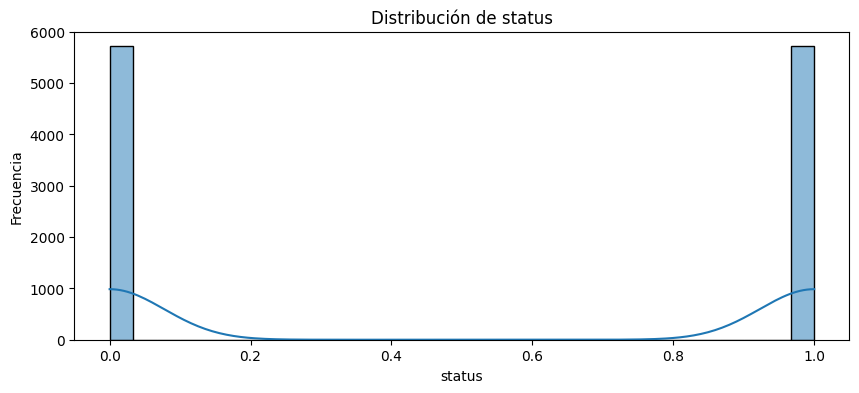

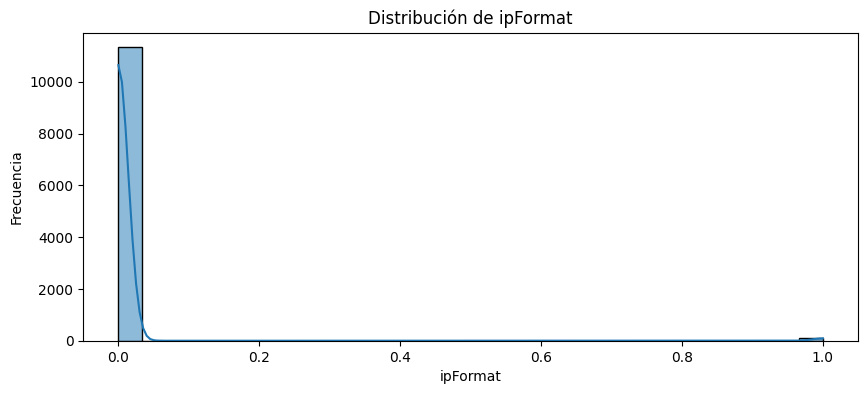

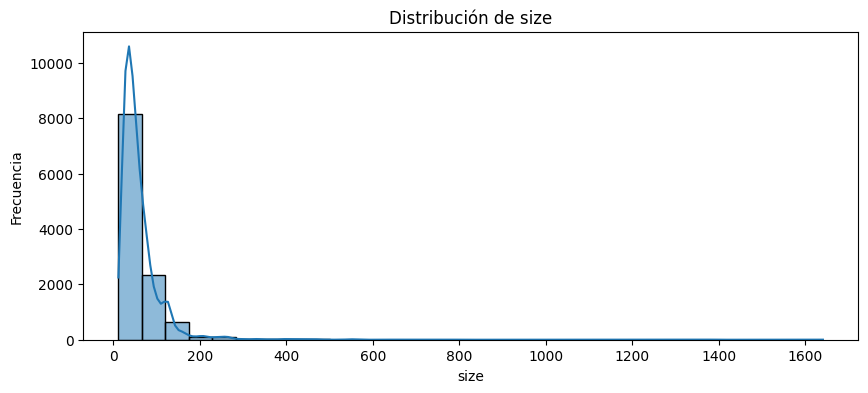

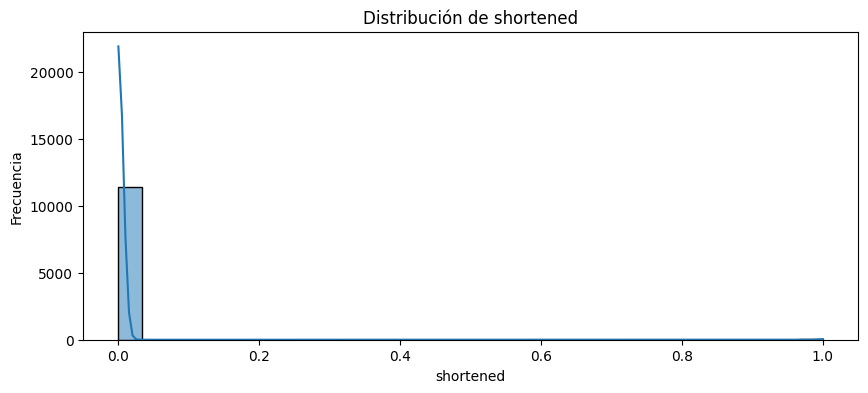

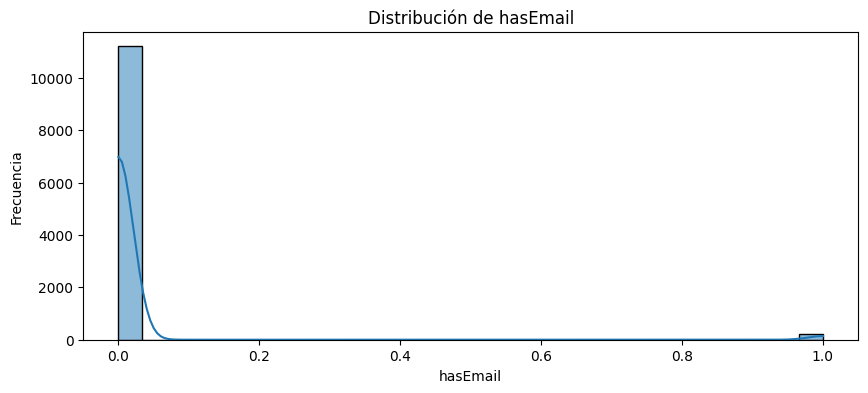

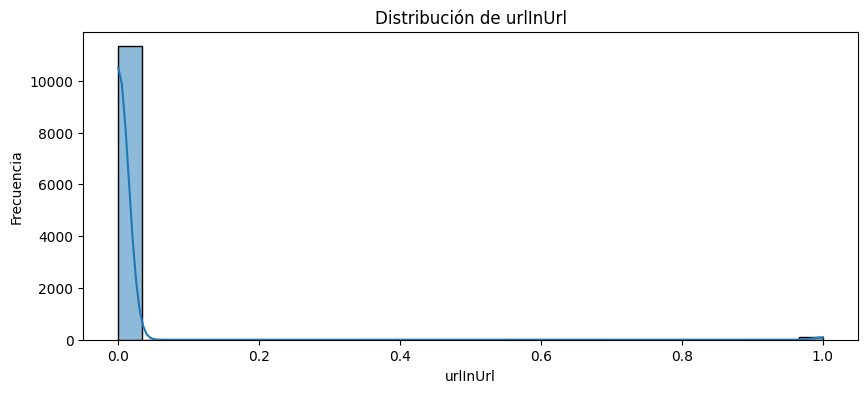

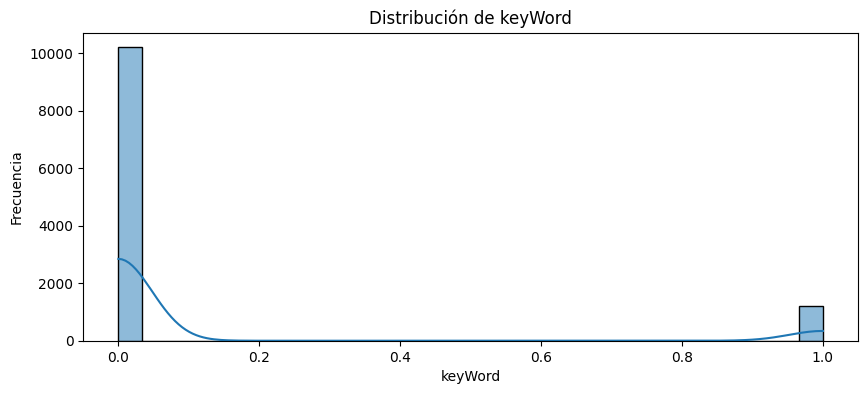

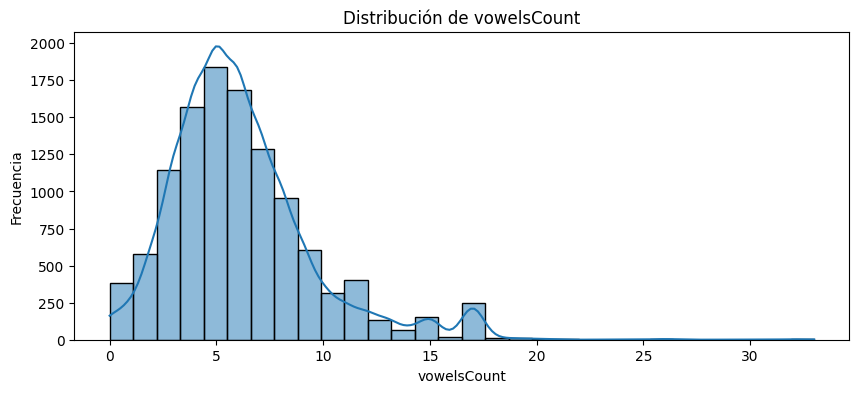

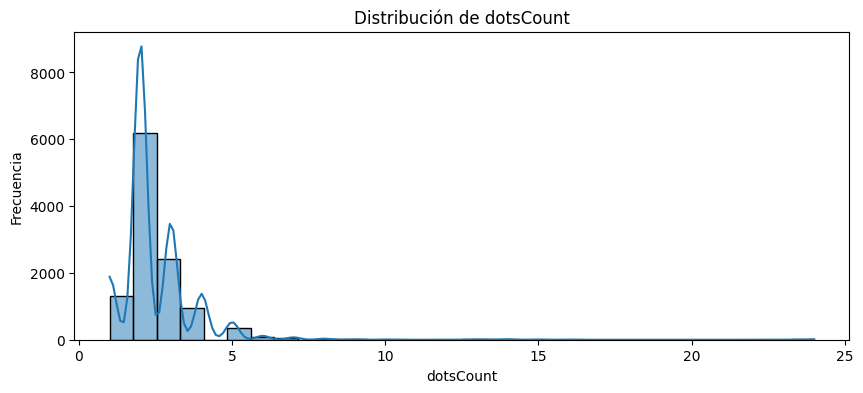

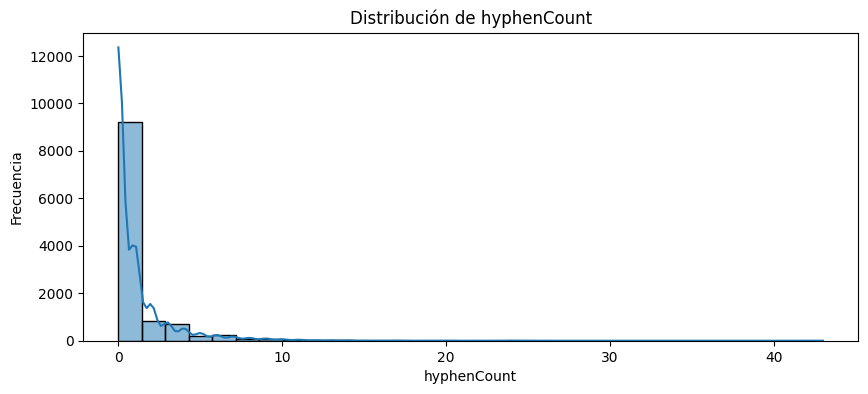

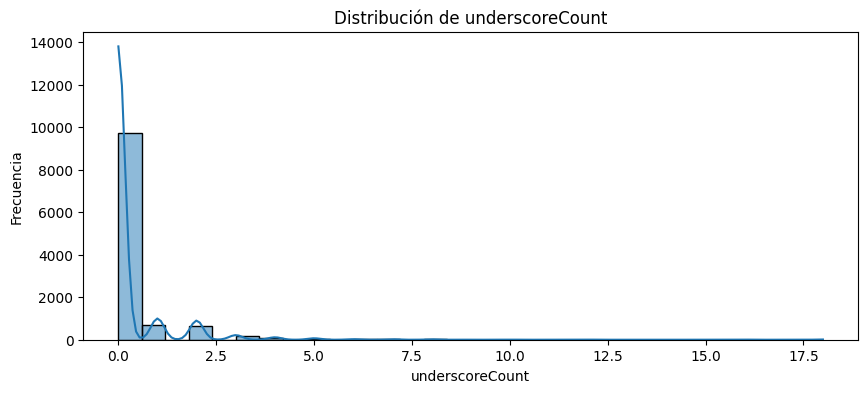

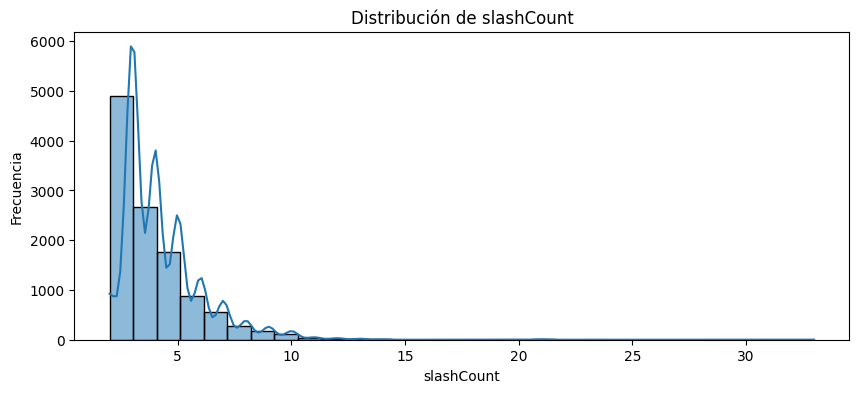

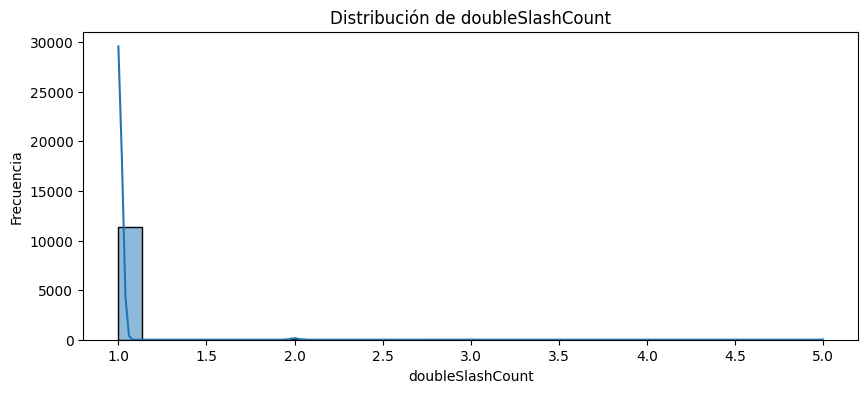

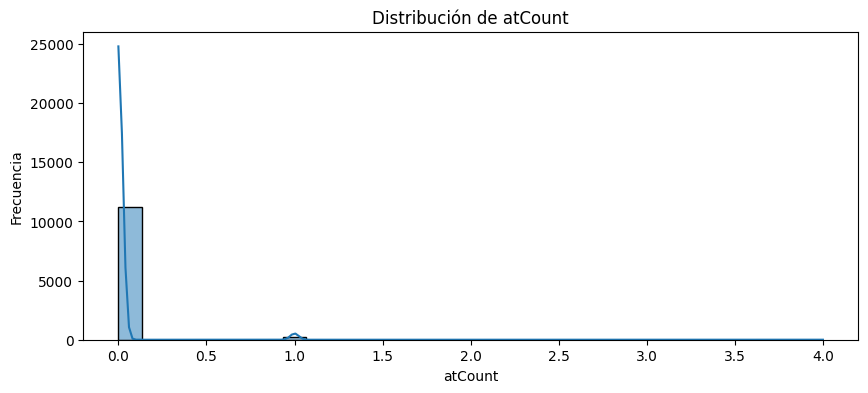

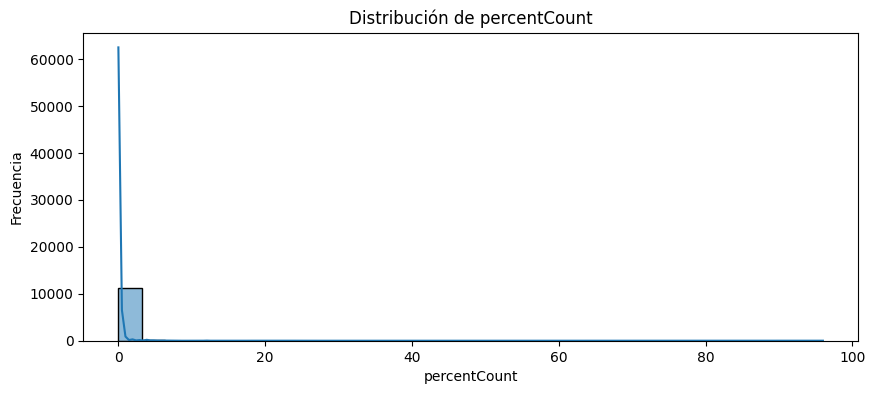

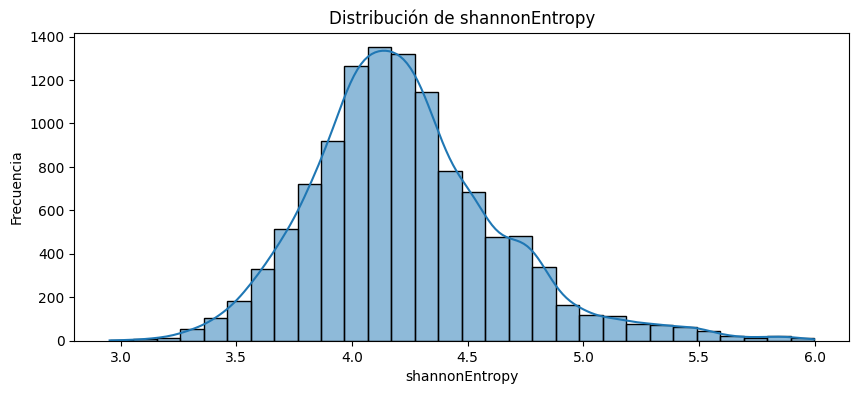

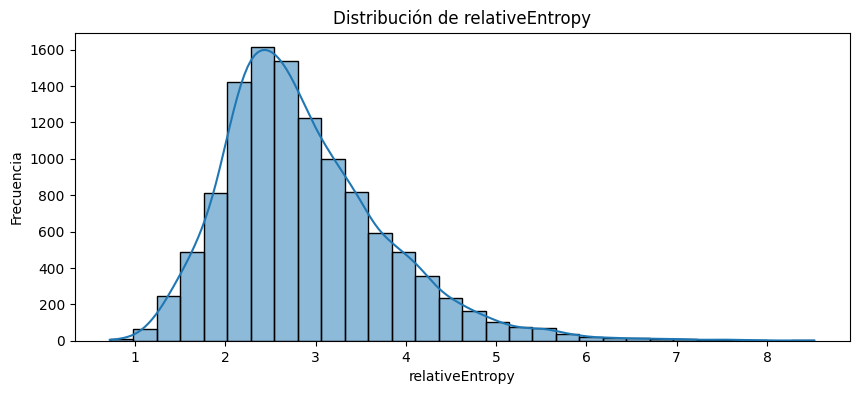

In [161]:
for columna in columnasNumericas:
    plt.figure(figsize=(10, 4))
    sns.histplot(finalDf[columna], kde=True, bins=30)
    plt.title(f'Distribución de {columna}')
    plt.xlabel(columna)
    plt.ylabel('Frecuencia')
    plt.show()

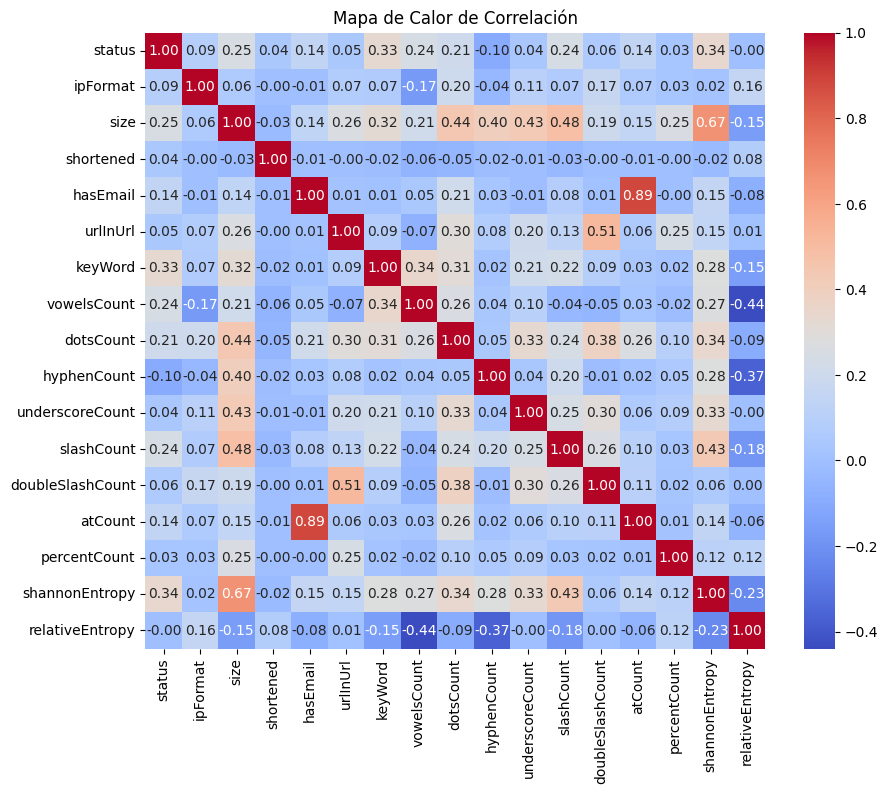

In [162]:
correlacion = finalDf.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Mapa de Calor de Correlación')
plt.show()

In [163]:
toNormalize = [
    'size',
    'vowelsCount',
    'dotsCount',
    'hyphenCount',
    'underscoreCount',
    'slashCount',
    'doubleSlashCount',
    'atCount',
    'percentCount',
    'shannonEntropy',
    'relativeEntropy'
]

scaler = StandardScaler()
finalDf[toNormalize] = scaler.fit_transform(finalDf[toNormalize])

In [164]:
X = finalDf.drop(['url', 'status', 'domain'], axis=1)
y = finalDf['status']

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=101,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.214,
    random_state=101,
    stratify=y_temp
)


In [165]:
X_train.to_csv("X_train.csv", index=False)
y_train.to_csv("y_train.csv", index=False)

X_val.to_csv("X_val.csv", index=False)
y_val.to_csv("y_val.csv", index=False)

X_test.to_csv("X_test.csv", index=False)
y_test.to_csv("y_test.csv", index=False)

## Implementación

In [166]:
# Función para generar matriz de confusión
def confusionMatrix(model, X, y, title):
    y_pred = model.predict(X)
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Legítimo", "Phishing"], yticklabels=["Legítimo", "Phishing"])
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title(f"Matriz de Confusión - {title}")
    plt.show()
    
# Función para generar reporte de clasificación	
def classificationReport(model, X, y, title):
    y_pred = model.predict(X)
    print(f"Reporte de Clasificación - {title}")
    print(classification_report(y, y_pred))
    
# Función para generar curva ROC y valor AUC
def rocCurve(model, X, y, title):
    y_pred_proba = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    auc_score = auc(fpr, tpr)
    
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
    plt.plot([0,1], [0,1], linestyle="--", color="gray")
    plt.xlabel("Tasa de Falsos Positivos")
    plt.ylabel("Tasa de Verdaderos Positivos")
    plt.title(f"Curva ROC - {title}")
    plt.legend()
    plt.show()

#### Modelo 1: Random Forest

In [167]:
rfModel = RandomForestClassifier(n_estimators=100, random_state=101)
rfModel.fit(X_train, y_train)

RandomForestClassifier(random_state=101)

Matriz de confusión

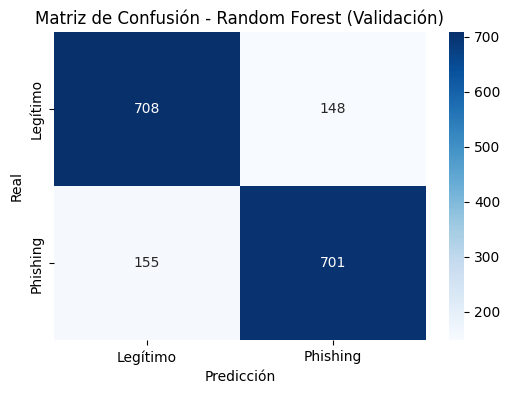

In [168]:
confusionMatrix(rfModel, X_val, y_val, "Random Forest (Validación)")

La matriz de confusión aunque parece buena, no está del todo bien. Pues en ella se puede apreciar que aunque clasificó correctamente la mayoría, hubieron varios que no. Clasificó a 155 phishings como legítimos (FN), y 148 legítimos como phishings (FP). Esto en la vida real no es ideal, ya que en estos casos tan delicados, que se clasifique correctamente es escencial.
Aunque es prematuro, se podría decir que el modelo no serviría del todo bien en un ambiente real, o bien, se debería buscar la manera de evitar esas malas clasificaciones para lanzarlo a un entorno de producción.

Precision & Recall

In [169]:
classificationReport(rfModel, X_val, y_val, "Random Forest (Validación)")

Reporte de Clasificación - Random Forest (Validación)
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       856
           1       0.83      0.82      0.82       856

    accuracy                           0.82      1712
   macro avg       0.82      0.82      0.82      1712
weighted avg       0.82      0.82      0.82      1712



El modelo presentó una precisión del 82% y 83% para las clases de legitimo y phishing, respectivamente. Y tal como se vió en la matriz de confusión, no fue del todo bien. Aunque una precisión promedio de 82.5% es buena, no es lo ideal. Debido a esto es que existen tantos False Positive (FP)

Por otra parte, el recall se obtuvo un 83% para legítimo y un 82% para phishing, tambien un valor aceptable pero no ideal. También se puede determinar porqué hay tantos False Negative (FN) en la matriz de confusión.

Curva ROC y valor AUC

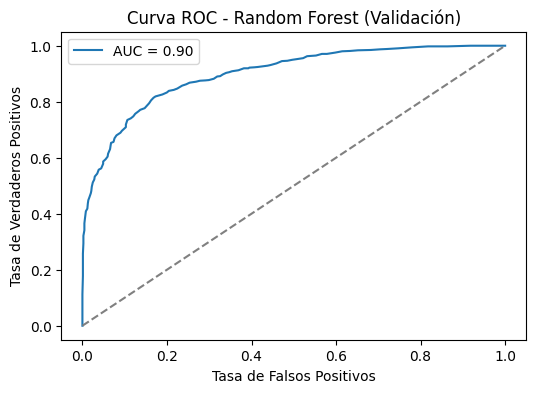

In [170]:
rocCurve(rfModel, X_val, y_val, "Random Forest (Validación)")

La curva ROC se ve, bueno, no tan curva. Podría ser mucho mejor. AUC nos ayuda a ponerle un número a eso tan mal que se ve la curva, un 0.9 indica que el modelo tuvo buen desempeño, pero no tan bueno. Clasificando la mayoría bien, pero clasificando el resto mal. Al igual que las otras dos métricas, se puede comprobar viendo la matriz de confusión y su alta cantidad de FP y FN.

#### Modelo 2: Regresión Logística

In [171]:
lrModel = LogisticRegression(max_iter=1000)
lrModel.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

Matriz de confusión

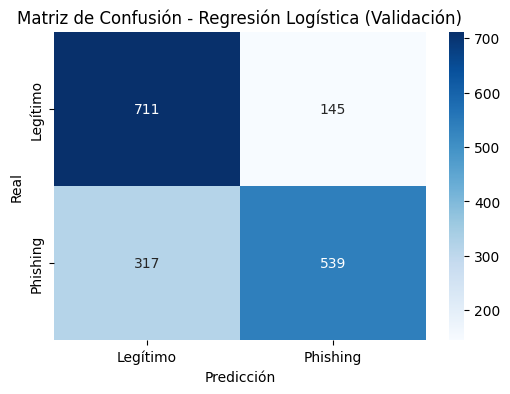

In [172]:
confusionMatrix(lrModel, X_val, y_val, "Regresión Logística (Validación)")


Esta matriz es una de las que se tiene que temer. Pues se ve claramente cómo hay una pésima clasificación y un gran valor de FN, absorviendo así a una alta cantidad de True Positive (TP) y evidenciando su mala clasificación. Y aunque la cantidad de FP es parecida a la del modelo anterior, el resto de sus valores hacen que este modelo desde ya sea peor.
No hay mucho que decir más que en este resumen se ve cómo el modelo no fue capaz de captar bien los patrones para lograr hacer una clasificación correcta.

Precision & Recall

In [173]:
classificationReport(lrModel, X_val, y_val, "Regresión Logística (Validación)")


Reporte de Clasificación - Regresión Logística (Validación)
              precision    recall  f1-score   support

           0       0.69      0.83      0.75       856
           1       0.79      0.63      0.70       856

    accuracy                           0.73      1712
   macro avg       0.74      0.73      0.73      1712
weighted avg       0.74      0.73      0.73      1712



Como era de esperarse, la precisión y el recall serían mucho más bajos que el modelo anterior. En esta regresión logística, el modelo no fue capaz de encontrar un equilibrio en sus variables, y por ende, no puede realizar correctamente una clasificación tomando en cuenta las features.
No se puede decir más que era de esperarse que el recall fuera tan bajo, ya que el modelo cuenta con una cantidad exagerada de FN. Tampoco es que la precisión fuera bueno, ya que en promedio es de 74%, haciendo que también hayan varios FP en la matriz de confusión.

Curva ROC y valor AUC

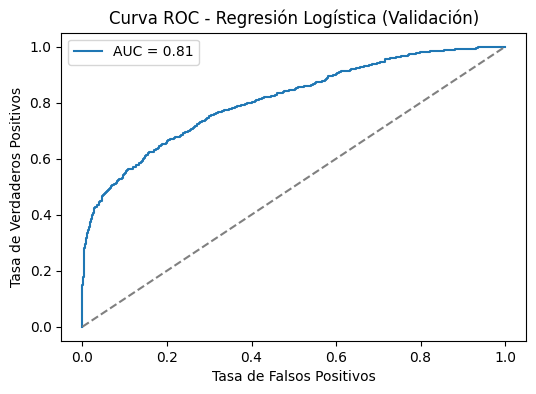

In [174]:
rocCurve(lrModel, X_val, y_val, "Regresión Logística (Validación)")


Con una diferencia significativa contra el random forest, la regresión logística tuvo un peor resultado en sus clasificaciones. Y en todas sus otras métricas se puede confirmar eso, debido a eso el valor de la AUC es así de bajo. Demostrando nuevamente lo malo que fue el modelo para clasificar los URL

## Discusión

#### ¿Cuál es el impacto de clasificar un sitio legítimo como phishing? 

R: Etiquetar un sitio legítimo como phishing de forma interna en la organización, puede llevar a que ciertos recursos necesarios que se encuentran en dicho dominio puedan no ser accesibles para los trabajadores que los requieran, así como llevar a dubitativas acerca de la confianza del modelo para clasificar correctamente el resto de sitios. Sin embargo, este Falso Positivo no causaría grandes problemas de seguridad, puesto que solamente se está restringiendo el acceso a un sitio benigno, aunque puede llegar a interrumpir ciertos procesos que dependan o requieran del contenido en este sitio.

#### ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo?

R: Este caso de un Falso Negativo, a diferencia del Falso Positivo, sí puede llegar a incurrir en un riesgo para la seguridad del sistema, puesto que el sitio estaría libre de ser consultado por cualquier usuario y ser víctimas de ataques maliciosos. El riesgo de este error de clasificación puede llegar a ser grave puesto que se deja la pauta de arriesgar información sensible para el sistema, como credenciales o información´clasificada importante. El no restringir un sitio malicioso deja abierta abierta la vulnerabilidad de sufrir ataques y robo de datos.

#### En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?

R: La métrica más adecuada para validar el comportamiento de los modelos, sería el Recall; puesto que al buscar evitar los Falsos Negativos, con un Recall más alto se asegura de que el modelo está haciendo un mayor esfuerzo por clasificar correctamente los sitios de phishing. Por otro lado, también sería prudente analizar el F1-score, el cual combina de forma balanceada tanto el Recall como la Precision del modelo.

#### ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?

R: El modelo Random Forest mostró un mejor desempeño:

+ Sitios legítimos

Precision: 0.82 (RF) / 0.69 (LR)  
Recall: 0.83 (RF) / 0.83 (LR)  
F1-score: 0.82 (RF) / 0.75 (LR)  

+ Sitios de phishing

Precision: 0.83 (RF) / 0.79 (LR)  
Recall: 0.82 (RF) / 0.63 (LR)  
F1-score: 0.82 (RF) / 0.70 (LR)  

+ AUC: 0.9 (RF) / 0.81 (LR)

Como se puede apreciar, el modelo de Random Forest presenta mejores resultados en ambas clasificaciones, además de poseer un valor AUC de 0.9, lo que indica una mejor capacidad para diferenciar entre sitios legítimos y de phishing.

Además, la curva ROC del modelo Random Forest se muestra más cercana a la región superior izquierda, lo que evidencia un mejor desempeño en general.

#### Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué propone para reducir la cantidad de falsas alarmas?

In [175]:
totalEmails = 50000
phishingEmails = 50000 * .15
legitimateEmils = 50000 * .85

In [176]:
# Datos de Random Forest
recall = 0.82
precision = 0.83
FPR = 148 / (148 + 708)
FNR = 155 / (155 + 701)
print(f"False Positive Rate: {FPR}")
print(f"False Negative Rate: {FNR}")

False Positive Rate: 0.17289719626168223
False Negative Rate: 0.1810747663551402


In [177]:
realCases = math.ceil((1- FNR) * phishingEmails)
fakeCases = math.ceil(FPR * (legitimateEmils))

totalAlarms = realCases + fakeCases

print(f"Total de alarmas generadas: {totalAlarms}")
print(f"Alarmas positivas: {realCases}")
print(f"Alarmas negativas (falsos positivos): {fakeCases}")

Total de alarmas generadas: 13491
Alarmas positivas: 6142
Alarmas negativas (falsos positivos): 7349


Con este resultado, podemos concluir que a pesar del buen desempeño del modelo en términos de Recall y Precision, también se encontró un FPR y FNR demasiado alto (17.82% y 18.1%, respectivamente) con lo cual se está generando una cantidad demasiado grande de falsas alarmas (7349). Con lo cual, la utilidad para el sistema podría verse comprometida ya que más del 54% de las alarmas generadas son falsas. 

Se concluye entonces que el modelo podría no ser suficientemente útil para el BR propuesto, sin embargo, para reducir la cantidad de falsas alarmas se puede seguir una de las siguientes alternativas:

+ Incrementar el umbral de clasificación para etiquetar un sitio como phishing, de manera que se reduzca el FPR, pero con la precaución de no elevar demasiado el FNR.
+ Agregar características de clasificación adicionales que permitan detectar un sitio web como phishing, esto quizá mediante el conocimiento de cuáles son los sitios de phishing más comunes dentro del propio sistema.
+ Implementar un modelo híbrido mediante heurísticas específicas que permitan refinar la detección de sitios de phishing.
+ Optimizar el FPR mediante técnicas como la penalización de los falsos positivos o ajustar el conjunto de datos de entrenamiento para reflejar mejor el BR propuesto.
+ Incorporar una revisión adicional de forma supervisada para validar los resultados del modelo.